In [315]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import minimize

In [291]:
df = pd.read_csv('data/stock_returns.csv')[['tic', 'date', 'close']].rename(columns={'tic': 'Ticker',
                                                                                     'close': 'Price',
                                                                                     'date': 'Date'})

In [292]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.sort_values(by=['Ticker', 'Date'], inplace=True)

In [293]:
df = df[df.Ticker != 'DOW']

In [294]:
df['Returns'] = df.groupby('Ticker')['Price'].pct_change()

In [295]:
window= 20

#### Utils

In [296]:
def portfolio_variance(weights, cov_matrix):
    return weights.dot(cov_matrix).dot(weights.T)

In [297]:
def mean_variance_optimization(returns_df, initial_weights):

    # Calculate the covariance matrix
    cov_matrix = returns_df.cov()   

    # Constraints: weights sum to 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) 

    # Bounds for weights: can't hold more than 100% of any stock
    bounds = tuple((0, 1) for _ in range(len(initial_weights)))

    # Optimization to
    result = minimize(portfolio_variance, initial_weights, args=(cov_matrix,),
                      method='SLSQP', bounds=bounds, constraints=constraints)

    return result.x if result.success else None

#### State Variables

In [298]:
# Initialize a dictionary to hold the allocations
allocations = {}

# Get unique dates
unique_dates = df['Date'].unique()

# Get unique tickers
tickers = df['Ticker'].unique()

# Initial weights (equal distribution)
initial_weights = np.array([1/len(tickers)] * len(tickers))

In [299]:
df = df[df.Date > pd.Timestamp('2010-12-30')]

#### Mean Variance Optimization

In [300]:
for date in unique_dates:

    # Filter the DataFrame for the current date and past year
    start_date = date - pd.DateOffset(years=1)
    past_year_data = df[(df['Date'] > start_date) & (df['Date'] <= date)]
   
    # Skip dates with insufficient data
    if past_year_data['Date'].nunique() < window:
        continue

    # Calculate the moving average of returns for the past year
    moving_avg_returns = past_year_data.groupby('Ticker')['Returns'].mean()

    # Create a DataFrame for the returns
    returns_df = past_year_data.pivot(index='Date', columns='Ticker', values='Returns').dropna()

    # Perform MVO
    optimal_weights = mean_variance_optimization(returns_df, initial_weights)

    # Store the allocations
    allocations[date] = dict(zip(tickers, optimal_weights))

In [301]:
# Convert allocations to a DataFrame
allocations_df = pd.DataFrame.from_dict(allocations, orient='index')

In [302]:
allocations_df.head()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
2011-01-28,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,...,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483
2011-01-31,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,...,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483
2011-02-01,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,...,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483
2011-02-02,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,...,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483
2011-02-03,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,...,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483


<br>

### Returns Analysis

In [303]:
df_prices = pd.read_csv('data/stock_returns.csv')[['tic', 'date', 'close']].rename(columns={'tic': 'Ticker',
                                                                                            'close': 'Price',
                                                                                            'date': 'Date'})

In [304]:
df_prices['Date'] = pd.to_datetime(df_prices['Date'], format='%Y-%m-%d')
df_prices['Returns'] = df_prices.groupby('Ticker')['Price'].pct_change()

In [305]:
df_returns = df_prices.pivot(index='Date', columns='Ticker', values='Returns')
df_allocations_aligned = allocations_df.reindex(df_returns.index, method='ffill')
portfolio_returns = (df_returns * df_allocations_aligned).sum(axis=1)

#### Plot Returns

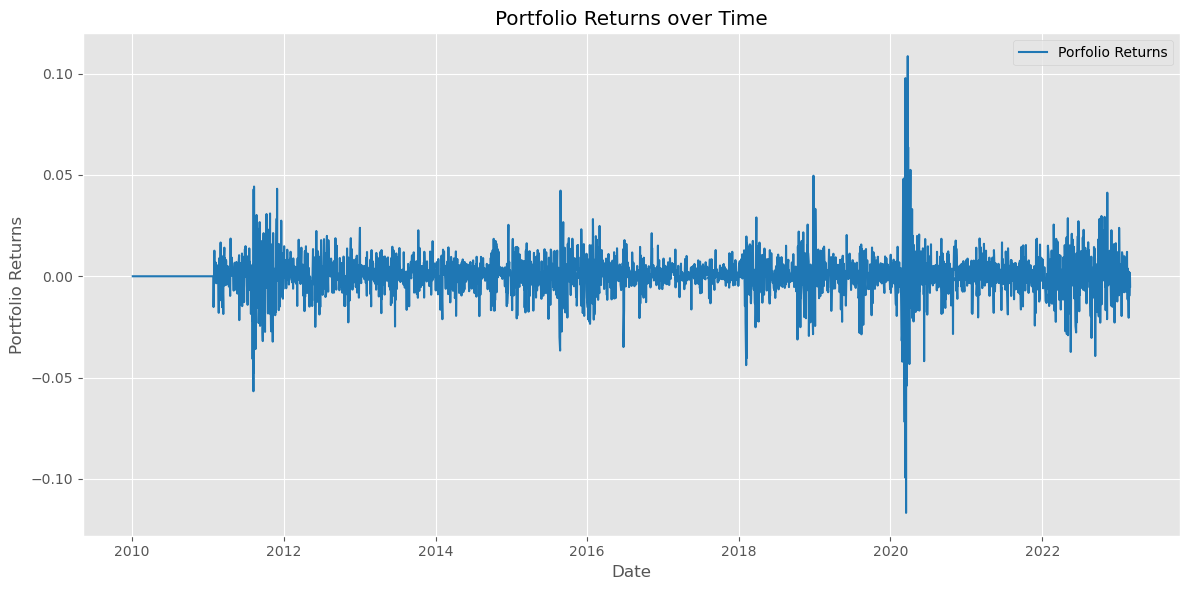

In [332]:
# Create plot
plt.figure(figsize=(12, 6))
plt.plot(portfolio_returns.index, portfolio_returns.values, label='Porfolio Returns', color='#1f77b4', linewidth=1.5)

plt.xlabel('Date')
plt.ylabel('Portfolio Returns')
plt.title('Portfolio Returns over Time')

plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

#### Plot Cumulative Returns

In [285]:
cumulative_returns_from_start_date = (1 + portfolio_returns).cumprod()-1

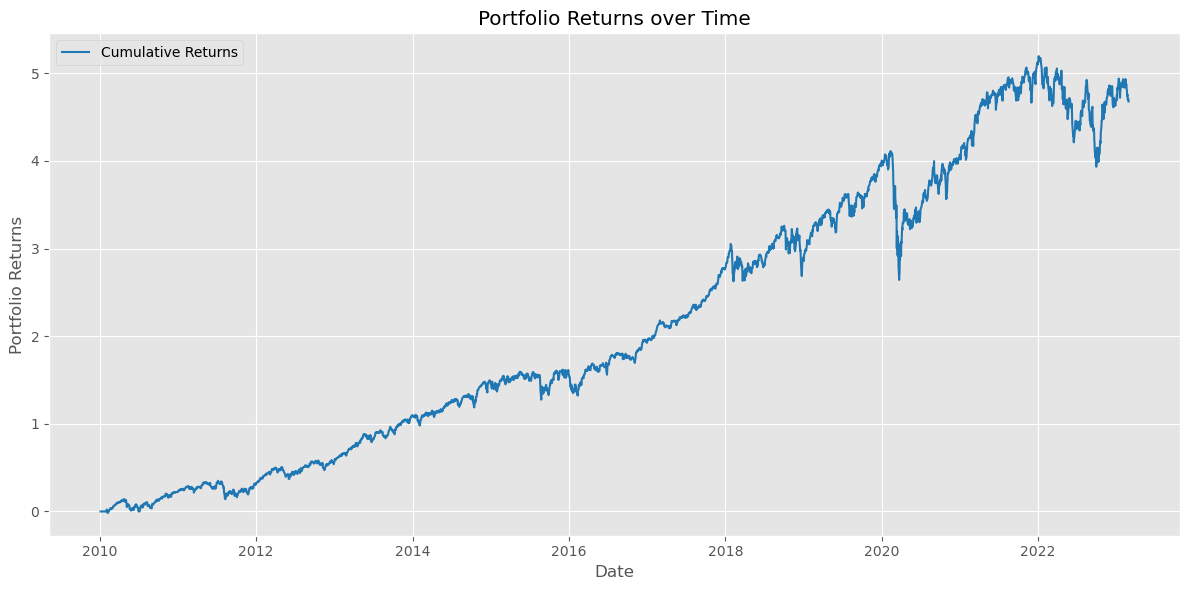

In [331]:
# Create plot
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns_from_start_date.index, cumulative_returns_from_start_date.values, label='Cumulative Returns', color='#1f77b4', linewidth=1.5)

plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns over Time')

plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

#### Save Results

In [337]:
portfolio_returns.to_frame(name='Returns').to_csv('MVO_returns.csv')

In [339]:
cd Desktop

C:\Users\Windows\Desktop
